In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/fake-and-real-news-dataset/True.csv


In [2]:
from numpy import array, asarray, zeros
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
from nltk.stem import PorterStemmer
stemming = PorterStemmer()

Using TensorFlow backend.


In [3]:
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
embedding = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake = fake.drop(['title','subject','date'], axis=1)

In [6]:
fake['text'].replace(' ', np.nan, inplace=True)
print(fake.count())
fake.dropna(subset = ["text"], inplace=True)
print(fake.count())
fake['validity']=0
fake.head()

text    22855
dtype: int64
text    22855
dtype: int64


,text,validity
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [7]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
true = true.drop(['title','subject','date'], axis=1)

In [9]:
true['text'].replace(' ', np.nan, inplace=True)
print(true.count())
true.dropna(subset = ["text"], inplace=True)
print(true.count())
true['validity']= 1
true.head()

text    21416
dtype: int64
text    21416
dtype: int64


,text,validity
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [10]:
data = pd.concat([fake,true], ignore_index=True, sort=False)

In [11]:
data.head()

,text,validity
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [12]:
data.describe()

,validity
count,44271.000000
mean,0.483748
std,0.499741
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
data.isnull().sum()

text        0
validity    0
dtype: int64

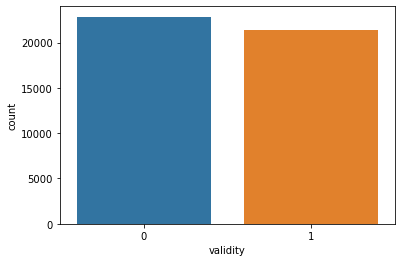

In [14]:
sns.countplot(x='validity', data=data)

In [15]:
def clean_data(sen):

    # Removing html tags
    sentence = re.sub(r'<[^>]+>', ' ', sen)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Removing single quote
    sentence = re.sub("'", ' ', sentence)
    
    #strip out non alphanumeric words/characters (such as numbers and punctuation) using .isalpha
    tokens = nltk.word_tokenize(sentence)
    # taken only words (not punctuation)
    sentence = [w for w in tokens if w.isalpha()]
    
    #Stemming reduces related words to a common stem
    sentence = [stemming.stem(word) for word in sentence]
    
    #Removing stop words
    sentence = [w for w in sentence if not w in stops]
    
    #Rejoin words to sentence
    sentence = ( " ".join(sentence))

    return sentence

In [16]:
X = []
sentences = list(data.text)
for sen in sentences:
    X.append(clean_data(sen))
#X

(-0.5, 399.5, 199.5, -0.5)

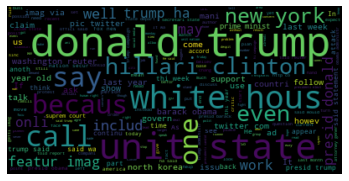

In [17]:
from wordcloud import WordCloud
merge_all_sentences= ' '.join(X)
wordcloud = WordCloud().generate(merge_all_sentences)
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")

In [18]:
y = data['validity']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [20]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [22]:
embeddings_dictionary = dict()
#print(embedding)
for line in embedding:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions


In [23]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    #print(embedding_vector)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [24]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          8536300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50001     
Total params: 8,586,301
Trainable params: 50,001
Non-trainable params: 8,536,300
_________________________________________________________________
None


In [26]:
fit_model = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.25)

Train on 29882 samples, validate on 9961 samples
Epoch 1/20
29882/29882 [==============================] - 2s 80us/step - loss: 0.1405 - acc: 0.9522 - val_loss: 0.0715 - val_acc: 0.9812
Epoch 2/20
29882/29882 [==============================] - 2s 68us/step - loss: 0.0230 - acc: 0.9970 - val_loss: 0.0564 - val_acc: 0.9830
Epoch 3/20
29882/29882 [==============================] - 2s 72us/step - loss: 0.0111 - acc: 0.9993 - val_loss: 0.0495 - val_acc: 0.9849
Epoch 4/20
29882/29882 [==============================] - 2s 72us/step - loss: 0.0071 - acc: 0.9995 - val_loss: 0.0477 - val_acc: 0.9853
Epoch 5/20
29882/29882 [==============================] - 2s 69us/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0468 - val_acc: 0.9862
Epoch 6/20
29882/29882 [==============================] - 2s 70us/step - loss: 0.0039 - acc: 0.9999 - val_loss: 0.0472 - val_acc: 0.9865
Epoch 7/20
29882/29882 [==============================] - 2s 67us/step - loss: 0.0031 - acc: 0.9999 - val_loss: 0.0460 - val_acc:

In [27]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = (model.predict(X_test) > 0.5).astype("int")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2247
           1       0.98      0.99      0.99      2181

    accuracy                           0.99      4428
   macro avg       0.99      0.99      0.99      4428
weighted avg       0.99      0.99      0.99      4428

